<a href="https://colab.research.google.com/github/ab-sa/Statistical-Machine-Learning-2/blob/main/Lecture6_GAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
#!pip install pygam
from pygam import GAM, s, te

In [2]:
Credit = pd.read_csv('Credit.csv')
print('Dimension of the data: ' + str(Credit.shape))
Credit.head()

Dimension of the data: (400, 12)


,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Generalised Additive Model (GAM):
There is a Python library in development for using GAMs (https://github.com/dswah/pyGAM), but it is not yet as comprehensive as the R GAM library, which we will use here instead.

To fit a GAM:

- Import the gam library
- Populate a formula including s() on variables we want to fit smooths for
- Call gam(formula, family=) where family is a string naming a probability distribution, chosen based on how the response variable is thought to occur.

This is a good manual on fitting different smoothers as well as GAM on a dataset in python:
https://harvard-iacs.github.io/2019-CS109B/labs/lab2/solutions/

Here is an examplee how you can fit a GAM on Credit data:

In [ ]:
Credit['Gender_str'] = pd.Series(Credit['Gender']).astype('string')
Credit['Student_str'] = pd.Series(Credit['Student']).astype('string')
Credit['Married_str'] = pd.Series(Credit['Married']).astype('string')
Credit['Ethnicity_str'] = pd.Series(Credit['Ethnicity']).astype('string')

display(Credit.dtypes)

ID                 int64
Income           float64
Limit              int64
Rating             int64
Cards              int64
Age                int64
Education          int64
Gender            object
Student           object
Married           object
Ethnicity         object
Balance            int64
Gender_str        string
Student_str       string
Married_str       string
Ethnicity_str     string
dtype: object

In [ ]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
# if you need to install gam package first:
#utils = importr('utils')
#utils.install_packages('gam')

X = pd.get_dummies(Credit.drop(['Balance', 'ID'], axis=1))
y = Credit['Balance']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam

r_Age = robjects.FloatVector(x_train[["Age"]].values)
r_Income = robjects.FloatVector(x_train[["Income"]].values)
r_Limit = robjects.FloatVector(x_train[["Limit"]].values)
r_Rating = robjects.FloatVector(x_train[["Rating"]].values)
r_Cards = robjects.FloatVector(x_train[["Cards"]].values)
r_Education = robjects.FloatVector(x_train[["Education"]].values)
r_Balance = robjects.FloatVector(y_train.values)
r_Gender = robjects.FactorVector(x_train["Gender_str"].values)
r_Student = robjects.FactorVector(x_train["Student_str"].values)
r_Married = robjects.FactorVector(x_train["Married_str"].values)
r_Ethnicity = robjects.FactorVector(x_train["Ethnicity_str"].values)

r_fmla = robjects.Formula("Balance ~ s(Age) + s(Income) + s(Limit) + s(Rating) + s(Cards) + s(Education) + Gender_str + Student_str + Married_str + Ethnicity_str")
r_fmla.environment['Balance'] = r_Balance
r_fmla.environment['Age'] = r_Age
r_fmla.environment['Limit'] = r_Limit
r_fmla.environment['Income'] = r_Income
r_fmla.environment['Rating'] = r_Rating
r_fmla.environment['Cards'] = r_Cards
r_fmla.environment['Education'] = r_Education
r_fmla.environment['Gender_str'] = r_Gender
r_fmla.environment['Student_str'] = r_Student
r_fmla.environment['Married_str'] = r_Married
r_fmla.environment['Ethnicity_str'] = r_Ethnicity

Balance_gam = r_gam(r_fmla)
print(Balance_gam.names)
print(Balance_gam.rx2('coefficients'))
print(Balance_gam.rx2('aic'))
print('sMSE: ', mean(pow(np.array(Balance_gam.rx2('residuals')), 2)))

 [1] "smooth.frame"        "coefficients"        "residuals"          
 [4] "fitted.values"       "effects"             "weights"            
 [7] "rank"                "assign"              "qr"                 
[10] "smooth"              "nl.df"               "df.residual"        
[13] "iter"                "var"                 "additive.predictors"
[16] "R"                   "rank"                "family"             
[19] "deviance"            "aic"                 "null.deviance"      
[22] "iter"                "bf.iter"             "prior.weights"      
[25] "y"                   "df.null"             "nl.chisq"           
[28] "model"               "call"                "formula"            
[31] "terms"               "data"                "offset"             
[34] "control"             "method"              "contrasts"          
[37] "xlevels"            

           (Intercept)                 s(Age)              s(Income) 
          -483.5902030             -0.8022569     

Prediction for GAM:

In [ ]:
from numpy.core.fromnumeric import mean
r_testSet = robjects.DataFrame({'Age': robjects.FloatVector(x_test[["Age"]].values), 
                               'Limit': robjects.FloatVector(x_test[["Limit"]].values), 
                               'Income': robjects.FloatVector(x_test[["Income"]].values),
                               'Rating': robjects.FloatVector(x_test[["Rating"]].values),
                               'Cards': robjects.FloatVector(x_test[["Cards"]].values),
                               'Education': robjects.FloatVector(x_test[["Education"]].values),
                               'Gender_str': robjects.FactorVector(x_test["Gender_str"].values),
                               'Student_str': robjects.FactorVector(x_test["Student_str"].values),
                               'Married_str': robjects.FactorVector(x_test["Married_str"].values),
                               'Ethnicity_str': robjects.FactorVector(x_test["Ethnicity_str"].values)})
r_predict = robjects.r['predict']
gam_preds = np.array(r_predict(Balance_gam, r_testSet))
print('MSPE: ', mean(pow(gam_preds - y_test, 2)))

MSPE:  2709.987861676896


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


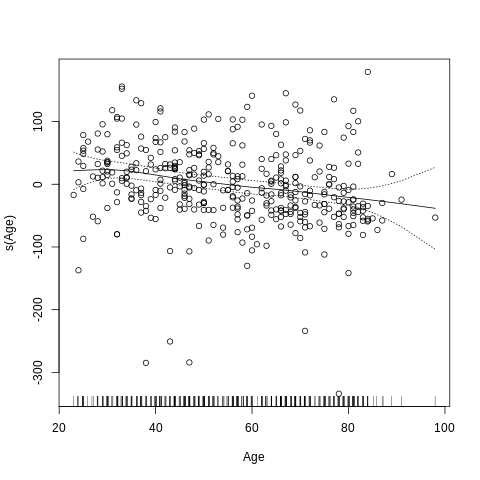

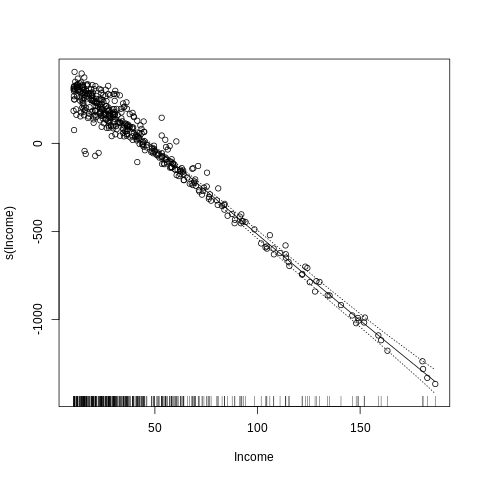

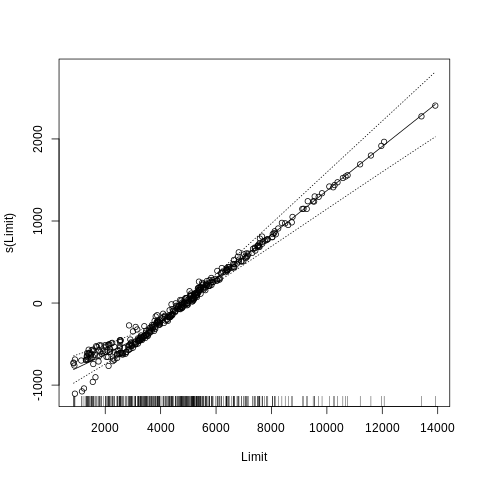

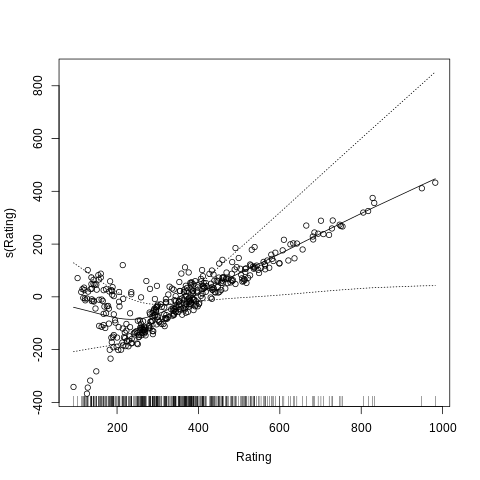

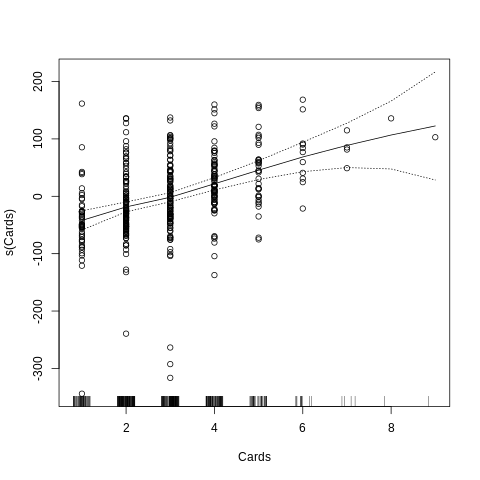

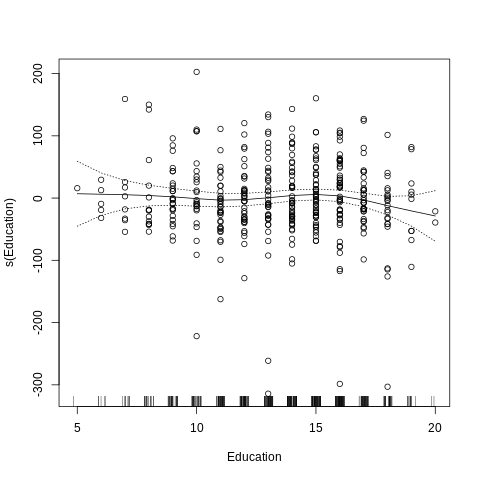

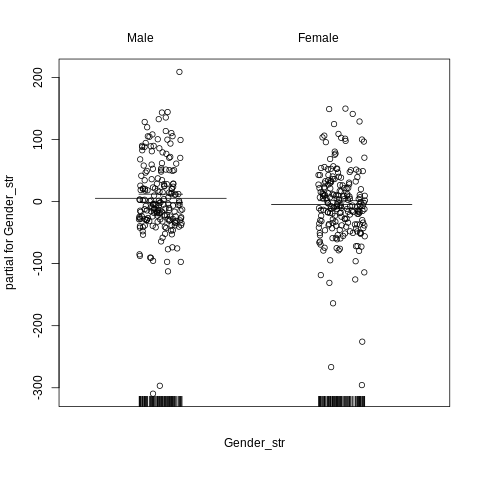

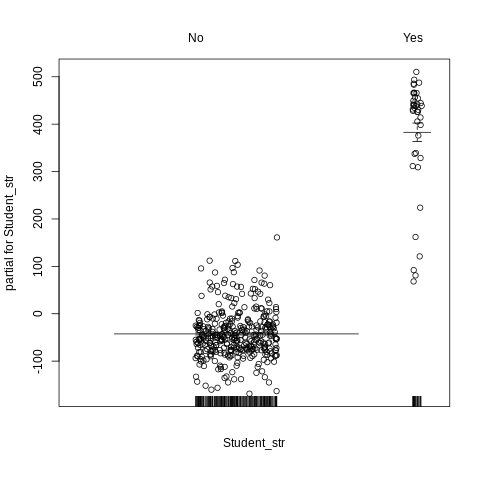

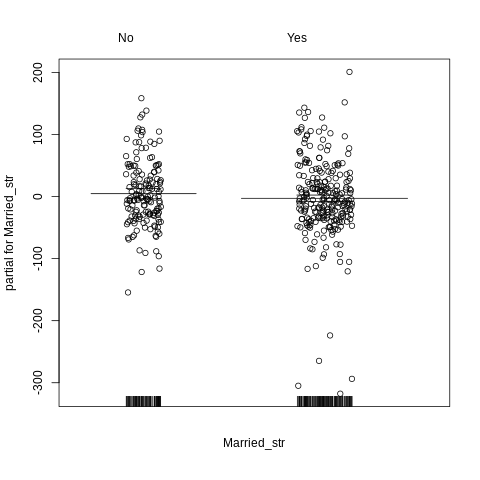

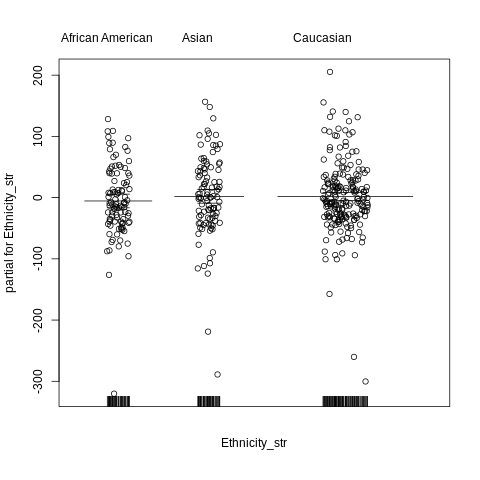

In [ ]:
%load_ext rpy2.ipython
%R -i Balance_gam plot(Balance_gam, residuals=TRUE,se=TRUE, scale=20);

Fit a similar GAM model by using pygam (simpler):

In [7]:
X = pd.get_dummies(Credit.drop(['Balance', 'ID'], axis=1))
y = Credit['Balance']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

gam=GAM(s(0)+s(1)+s(2)+s(3)+s(4)).fit(x_train[['Age', 'Income', 'Rating', 'Limit', 'Cards']],y_train)
gam.gridsearch(X=x_train, y=y_train, lam=np.linspace(0, 10, 100), return_scores=True)
gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.4338
Link Function:                     IdentityLink Log Likelihood:                                 -3456.4048
Number of Samples:                          320 AIC:                                             6947.6772
                                                AICc:                                            6949.8085
                                                GCV:                                            21564.5881
                                                Scale:                                          19580.7495
                                                Pseudo R-Squared:                                   0.9129
Feature Function                  Lam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  import sys
